# Notebook 2-2 Clustering Model Selection

Readme: In this notebook, clustering model is constructed, using three types of models to cluster.

- **Cluster Method this notebook:**

     - k-means clustering

     - DBSCAN clustering

     - Agglomerative clustering

- **Performance Metrics**:

    - ARI, NMI, and Cosine Similarity

Note: Different method has different ways to evaluate.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and evaluation imports
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score,
    normalized_mutual_info_score, pairwise_distances,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [71]:
# 1) Read data
train_file = r"Dataset2_train.csv"
test_file = r"Dataset2_test.csv"
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)


df = pd.concat([df_train, df_test], ignore_index=True)
print("Data loaded. Shape:", df.shape)

# 2) Clean missing values
df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
df['Energy Consumption per Distance MJ/100km'].fillna(
    df['Energy Consumption per Distance MJ/100km'].mean(), inplace=True
)
print("Missing values filled.")


Data loaded. Shape: (14768, 29)
Missing values filled.


C:\Users\87383\AppData\Local\Temp\ipykernel_102836\1589338034.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
C:\Users\87383\AppData\Local\Temp\ipykernel_102836\1589338034.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Missing values filled.
Binary label CO2_Class created.
Features scaled.


C:\Users\87383\AppData\Local\Temp\ipykernel_102836\868531421.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
C:\Users\87383\AppData\Local\Temp\ipykernel_102836\868531421.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

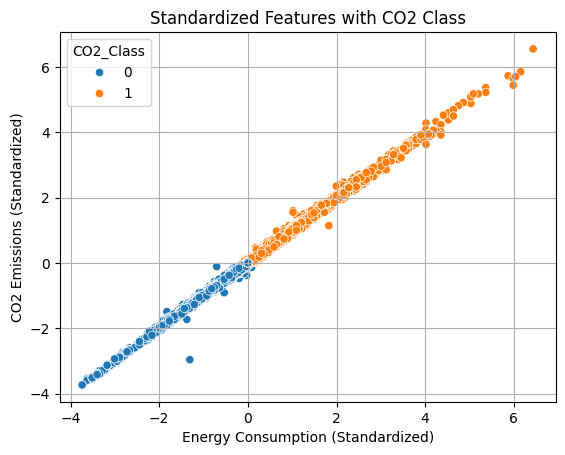

In [72]:
# 2) Clean missing values
df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
df['Energy Consumption per Distance MJ/100km'].fillna(
    df['Energy Consumption per Distance MJ/100km'].mean(), inplace=True
)
print("Missing values filled.")

# Create binary label for evaluation
median_co2 = df['CO2 Emissions(g/km)'].median()
df['CO2_Class'] = (df['CO2 Emissions(g/km)'] > median_co2).astype(int)
print("Binary label CO2_Class created.")

# 3) Select features and standardize
X = df[['Energy Consumption per Distance MJ/100km', 'CO2 Emissions(g/km)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# Visualize features
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['CO2_Class'])
plt.title("Standardized Features with CO2 Class")
plt.xlabel("Energy Consumption (Standardized)")
plt.ylabel("CO2 Emissions (Standardized)")
plt.grid(True)
plt.show()

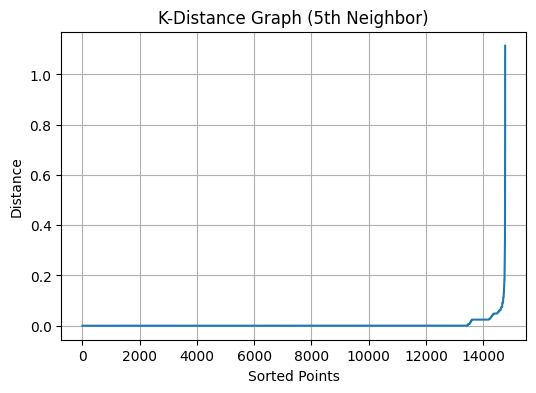

Suggested eps from k-distance graph: 0.7551578833343088


In [73]:
# 4) Plot k-distance graph for DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.title("K-Distance Graph (5th Neighbor)")
plt.xlabel("Sorted Points")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

eps_candidate = distances[np.argmax(np.diff(distances))]
print("Suggested eps from k-distance graph:", eps_candidate)

DBSCAN finished. Number of clusters: 18


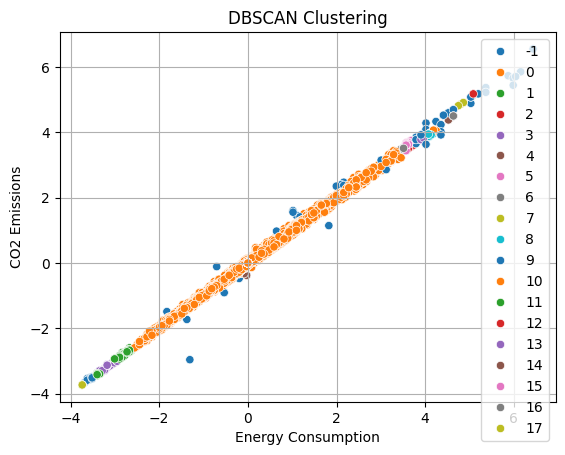

In [74]:
# 5) DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = dbscan_labels
print("DBSCAN finished. Number of clusters:", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

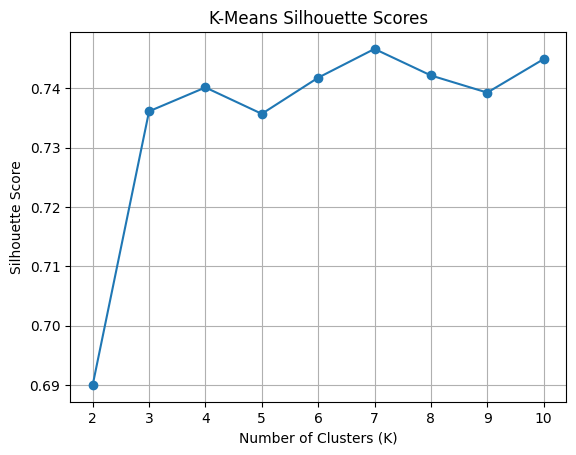

Optimal K for K-Means: 7


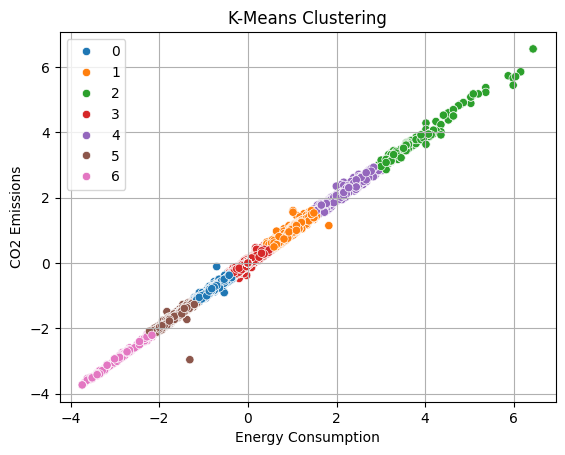

In [75]:
# 6) K-Means with silhouette scores
k_values = range(2, 11)
kmeans_sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    kmeans_sil_scores.append(sil)

plt.plot(k_values, kmeans_sil_scores, marker='o')
plt.title("K-Means Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = k_values[np.argmax(kmeans_sil_scores)]
print("Optimal K for K-Means:", optimal_k)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = kmeans_labels

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("K-Means Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

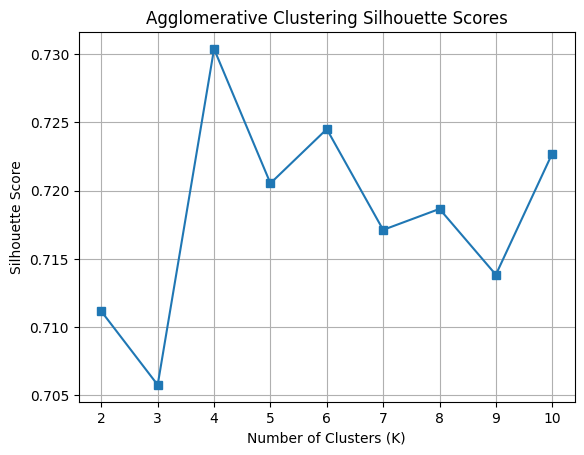

Optimal K for Agglomerative Clustering: 4


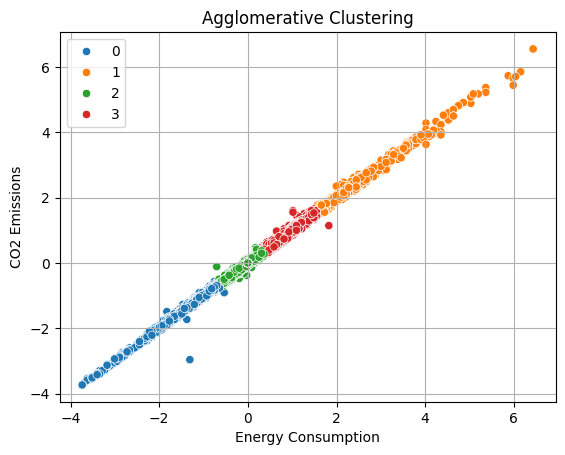

In [76]:
# 7) Agglomerative Clustering
agg_sil_scores = []
for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    agg_sil_scores.append(sil)

plt.plot(k_values, agg_sil_scores, marker='s')
plt.title("Agglomerative Clustering Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k_agg = k_values[np.argmax(agg_sil_scores)]
print("Optimal K for Agglomerative Clustering:", optimal_k_agg)

agg_model = AgglomerativeClustering(n_clusters=optimal_k_agg)
agg_labels = agg_model.fit_predict(X_scaled)
df['Agglomerative_Cluster'] = agg_labels

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=agg_labels, palette='tab10')
plt.title("Agglomerative Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

In [77]:
# 8) Evaluation function
def evaluate_model(true_binary, predicted_cluster):
    ari = adjusted_rand_score(true_binary, predicted_cluster)
    nmi = normalized_mutual_info_score(true_binary, predicted_cluster)
    true_vals = df[['CO2 Emissions(g/km)']].values.reshape(-1, 1)
    pred_vals = predicted_cluster.reshape(-1, 1)
    cos_sim = 1 - pairwise_distances(true_vals, pred_vals, metric='cosine').mean()
    return ari, nmi, cos_sim

dbscan_ari, dbscan_nmi, dbscan_cos = evaluate_model(df['CO2_Class'], dbscan_labels)
kmeans_ari, kmeans_nmi, kmeans_cos = evaluate_model(df['CO2_Class'], kmeans_labels)
agg_ari, agg_nmi, agg_cos = evaluate_model(df['CO2_Class'], agg_labels)

results = pd.DataFrame({
    'Model': ['DBSCAN', 'K-Means', 'Agglomerative'],
    'ARI': [dbscan_ari, kmeans_ari, agg_ari],
    'NMI': [dbscan_nmi, kmeans_nmi, agg_nmi],
    'Cosine_Sim': [dbscan_cos, kmeans_cos, agg_cos]
})

results_sorted = results.sort_values(
    by=['ARI', 'NMI', 'Cosine_Sim'], ascending=False
).reset_index(drop=True)

print("\nEvaluation Results:")
print(results_sorted)

best_model = results_sorted.loc[0, 'Model']
print("\nBest model based on ARI, NMI, and Cosine Similarity:", best_model)


Evaluation Results:
           Model       ARI       NMI  Cosine_Sim
0  Agglomerative  0.411414  0.470142    0.823402
1        K-Means  0.289182  0.369791    0.891928
2         DBSCAN  0.028919  0.043333    0.010631

Best model based on ARI, NMI, and Cosine Similarity: Agglomerative


In [78]:
# 9) Save to CSV
trainset = df.iloc[0:5907, ]
testset = df.iloc[5907:, ]

trainset.to_csv("Workstream_1_ML_models/Trainset_with_cluster_label.csv", index=False)
testset.to_csv("Workstream_1_ML_models/Testset_with_cluster_label.csv", index=False)

print(f"\nFinal results saved.")


Final results saved.
